Color/Density as Proxies for Serpentinization
=============================================



## Introduction



Not all samples had corresponding thin sections from which a degree of serpentinization could be inferred. Instead, proxies can be used to infer the degree of serpentinization:

-   Color
-   Density \citep{Otofuji2021,Miller1997}



## Color



### Reading the Data



Images of hand sample cut faces were taken under similar lighting and camera exposure conditions. These were then cropped to rectangles to remove the background and non-flat regions, and then named by sample, slice index and face in `../DATASETS/PHYSICAL/sample_imagery/`. Each sample can be represented by multiple images, and opposing faces (of a singular cut) are not repeated.

The images are first loaded as RGB arrays, which are split into the separate bands before a whole-image mean (and standard deviation) are computed. Since this is a computationally expensive process, the results are stored to disk in the file `./local_data/colors.csv`, which is read into the kernel if already present (i.e. to rerun the code, just delete that file).



In [1]:
from PIL import Image
import os
import numpy as np
import pandas as pd

# Declare path to save per-sample color data extracted from images.
color_datafile = os.path.join("local_data","colors.csv")
# Declare folder containing images.
samples_dir = os.path.join("..","DATASETS","PHYSICAL","sample_imagery")

# Check if a previous data save file exists and load color data from there if so.
if os.path.exists(color_datafile):
    print(f"Reading data from existing file {color_datafile}")
    color_df = pd.read_csv(color_datafile,index_col=0)
else:
    # Otherwise regenerate the color data.
    print(f"Regenerating data from images in folder {samples_dir}")
    # Initialize dict to store per-pixel color data.
    data = dict()
    # Iterate through sample face image filenames in the images folder.
    for sample_face in os.listdir(samples_dir):
        # Identify the sample from filename.
        sample = sample_face.split(".")[0]
        # Initialize an entry for the sample with 3 color bands + value if not already present in the data storage dict.
        if sample not in data:
            data[sample] = dict(R=[],G=[],B=[],val=[])
        # Load the active sample face into an image.
        img = Image.open(os.path.join(samples_dir,sample_face))
        # Convert image into a numpy array of RGB(A).
        img_arr = np.array(img)
        # Flatten image array into a 1D array of RGB(A) sub-arrays.
        flat_arr = np.reshape(img_arr,(img_arr.shape[0]*img_arr.shape[1],img_arr.shape[2]))
        # Check if the image contains an alpha channel and filter for only the pixels that are fully opaque if so.
        if img.mode == "RGBA":
            flat_arr = flat_arr[flat_arr[:,3]==255]
        # Split the flattened array into RGB bands.
        R,G,B = flat_arr[:,0],flat_arr[:,1],flat_arr[:,2]
        # Compute the value of each pixel.
        val = flat_arr[:,:3].mean(axis=1)
        # Store the R,G,B,val for each pixel in separate lists.
        data[sample]["R"].extend(list(R))
        data[sample]["G"].extend(list(G))
        data[sample]["B"].extend(list(B))
        data[sample]["val"].extend(list(val))

    # Initialize dict to store aggregated per-sample color data.
    aggregated_data = dict()
    # Iterate through samples.
    for sample in data:
        # Initialize dict to store aggregated color data for the active sample.
        aggregated_data[sample] = dict()
        # Iterate through the color parameters.
        for c in ["R","G","B","val"]:
            # Extract the per-pixel data for the active color parameter for the active sample.
            sample_c_data = data[sample][c]
            # Compute and store the mean of this color parameter's data.
            aggregated_data[sample][c] = np.mean(sample_c_data)
            # Compute and store the stdev of this color parameter's data.
            aggregated_data[sample][f"{c}_stdev"] = np.std(sample_c_data)
    # Convert the per-sample data from dict into a pandas df with row-wise samples.
    color_df = pd.DataFrame().from_dict(aggregated_data).T
    # Save the df to disk.
    color_df.to_csv(color_datafile)

Reading data from existing file local_data/colors.csv


## Density



### Loading the Data



Mass and volume measurement results are stored in `../DATASETS/PHYSICAL/masses_volumes.csv`. Multiple measurements were made for each property, with the measurement index being appended to the column names.

-   Masses were all measured $&ge;$3 times on 19/2/2024
-   First set of volumes (using the volume difference method after submergence in water): 19/2/2024
-   Second set of volumes: 21/2/2024 (the time gap permitted drying of the samples)
-   Third set of volumes: 27/2/2024
-   Fourth set of volumes: 29/2/2024



In [2]:
# Load mass and volume data from disk.
df = pd.read_csv(os.path.join("..","DATASETS","PHYSICAL","masses_volumes.csv"),index_col=0)
# Identify the volume columns (with each set of volume measurements being represented by 3 columns: volume at start, volume after addition of sample, volume capacity of measuring cylinder).
volume_cols = [c for c in df.columns if "vol" in c]
# Iterate through the number of measurement sets.
for i in range(1,int(len(volume_cols)/3)+1):
    # Identify the columns for volume at start and volume after sample addition for the active measurement set.
    vol_start = df[f"vol_water_{i:d}"]
    vol_end = df[f"vol_water_sample_{i:d}"]
    # Compute the volume of the samples by difference.
    vol_sample = vol_end - vol_start
    # Store the sample volumes into the same df.
    df[f"vol_{i:d}"] = vol_sample

The mass and volume data are first summarized in a mean and uncertainty (half the range divided by the mean), and then density computed (alongside density uncertain as a sum of the mass and volume uncertainties).



In [3]:
# Find the names of the sample volume columns.
vol_cols = [c for c in df.columns if "vol" in c and not ("water" in c or "cylinder" in c)]
# Find the names of the sample mass columns.
mass_cols = [c for c in df.columns if "mass" in c]
# Function to find the half ranges of values across rows in a 2D array, returning a 1D array (column) of half ranges.
rowwise_half_range_arr = lambda data_arr : ((np.nanmax(data_arr,axis=1) - np.nanmin(data_arr,axis=1))/2)
# Isolate sample volumes into a df.
vol_df = df[vol_cols]
# Isolate sample masses into a df.
mass_df = df[mass_cols]
# Compute volume means.
vol_mean = np.nanmean(vol_df,axis=1)
# Compute volume uncertainties (half range as fraction of mean).
vol_uncert = rowwise_half_range_arr(vol_df)/vol_mean
# Do the same for mass.
mass_mean = np.nanmean(mass_df,axis=1)
mass_uncert = rowwise_half_range_arr(mass_df)/mass_mean
# Compute density (mass/volume).
density_mean = mass_mean/vol_mean
# Compute density uncertainties by summing the uncertainties of the constituent measurements.
density_uncert = mass_uncert + vol_uncert

## Density vs Color Plots



With density and color both intending to be used to represent the degree of serpentinisation, a relation should be present when the two are scatterplotted against each other. The color parameter to investigate will be the value, but can be changed to a color band if desired.



/home/generic/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


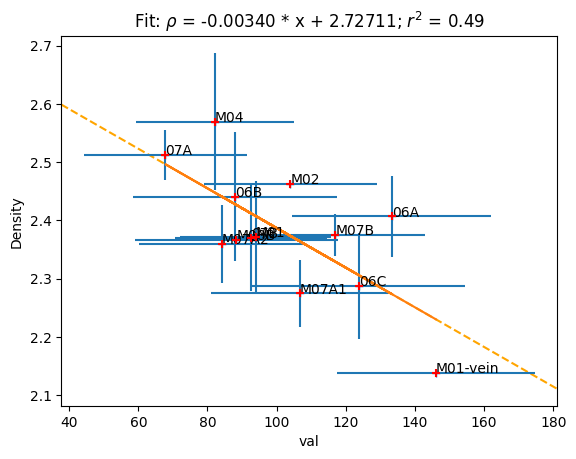

In [4]:
# Declare the color parameter to focus on.
color_param = "val" # or one out of {"R","G","B"}

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Define a linear mapping.
linear_func = lambda x,a,b : a*x + b
# Order the color dataframe to have the same sample order as the mass (and density) values.
color_df = color_df.reindex(mass_df.index)
# Initialize plot.
fig,ax = plt.subplots()
# Define x (color) and y (density) variables.
x = color_df[color_param].to_list()
y = list(density_mean) # rho (density)
# Plot the xy points with corresponding error bars.
ax.scatter(x,y,marker="+",c="r",zorder=1000)
ax.errorbar(x,y,xerr=color_df[f"{color_param}_stdev"],yerr=density_uncert,linestyle="none",marker="+")
# Label each point with the corresponding sample.
[ax.text(xi,yi,sample) for xi,yi,sample in zip(x,y,mass_df.index)]
# Produce a linear fit to the data.
popt,pcov = curve_fit(linear_func,x,y)
# Find the expected densities at each color point given the best-fit linear model.
model_rho = linear_func(np.array(x),*popt)
# Compute the r2 for the linear fit.
r2 = r2_score(y,model_rho)
# Plot the linear model (in the region of the data).
ax.plot(x,model_rho)
# Plot the extrapolated linear model
x_full = ax.get_xlim()
ax.plot(x_full,linear_func(np.array(x_full),*popt),linestyle="--",c="orange",zorder=-10)
ax.set_xlim(x_full)
# Display the linear model and r2 in the plot title.
ax.set_title(f"Fit: $\\rho$ = {popt[0]:.5f} * x + {popt[1]:.5f}; $r^2$ = {r2:.2f}")
# Label the axes.
ax.set_xlabel(color_param)
ax.set_ylabel("Density")

plt.show()

Assuming a linear relationship, there seems to be a decrease in density as value/brightness increases, which makes sense as serpentinisation (accompanied by silica increase) produces lighter minerals (in both density and color) compared to mantle minerals: i.e. olivine and pyroxene &rarr; serpentinite.



## Ordering by Degree of Serpentinization



The lack of a perfect linear relationship between color (value) and density means they may not be equally suitable for interpolating the degree of serpentinization. The samples are ordered by color vs by density and then the degree of serpentinization (from thin section analysis) indicated to check how well each ordering differentiates between partially and heavily serpentinized samples.



/tmp/ipykernel_7268/2377462550.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mass_df["density"] = density_mean


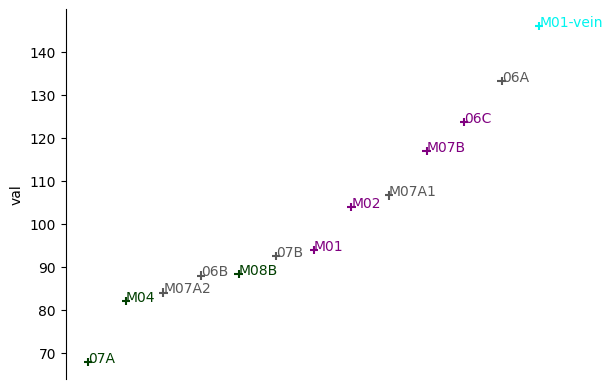

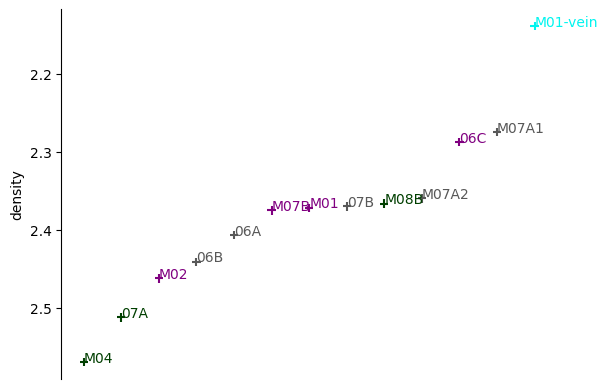

In [5]:
import sys
# Import observed degree of serpentinization and colormapping data.
sys.path.insert(0,os.path.join("..","DATASETS","SERP"))
from sample_serp import serp,cmap

# Place the computed density into the mass dataframe.
mass_df["density"] = density_mean

def plot_ordered_physical_param(param_df,param):
    ''' Highly specific function for plotting a chart to compare the values of a computed serpentinization proxy against observed levels of serpentinization.

    param_df | :pandas.DataFrame: | Dataframe with sample names as the index and containing the computed serpentinization proxy in one of the columns.
    param | :str: | Name of the column in param_df containing the computed serpentinization proxy.

    Returns: :matplotlib.axes.Axes:
    '''
    # Rank the dataframe (including the samples) by the requested serpentinization proxy.
    ordered_df = param_df.sort_values(param)
    # Initialize plot.
    fig,ax = plt.subplots()
    # Get list of colors for the samples in the order of the ranked dataframe. Samples without a degree of serpentinization observation are set to plot as grey.
    sample_c_list = [(cmap[serp[sample]] if sample in serp else "#585858") for sample in ordered_df.index]
    # Declare the x (numerical index) and y (value of the serpentinization proxy) variables to scatterplot.
    x = range(len(ordered_df))
    y = ordered_df[param]
    # Plot these points with their corresponding colors.
    ax.scatter(x,y,c=sample_c_list,marker="+")
    # Label each point with their respective sample in the same color.
    [ax.text(xi,yi,sample,c=color) for xi,yi,sample,color in zip(x,y,ordered_df.index,sample_c_list)]
    # Label y axis with the name of the serpentinization proxy.
    ax.set_ylabel(param)
    # Remove all axes decorations except the left y axis.
    ax.spines[["top","right","bottom"]].set_visible(False)
    ax.set_xticks([],[])
    return ax

# Plot a comparison of the color serpentinization proxy and observed serpentinization level.
plot_ordered_physical_param(color_df,color_param)
# Plot a comparison of the density serpentinization proxy and observed serpentinization level.
ax = plot_ordered_physical_param(mass_df,"density")
# Invert both x and y axis for the density comparison to match the direction of increasing serpentinization in the color comparison.
ax.invert_xaxis()
ax.invert_yaxis()

plt.show()

These plots show partially serpentinized samples in green and heavily serpentinized samples in purple (and the vein sample in light blue). The axes in the density plot are oriented to match the directions of increasing serpentinization in the color plot (i.e. increasing to the right and upwards).

-   The density ordering is unable to fully distinguish between partially and heavily serpentinized samples (see the position of M08).
-   Therefore the color ordering will be used to infer the degree of serpentinization of samples without thin section observations.

